# Bayesian vs Frequentist Regularization — Unified Comparative Framework

## Objective

Compare **Bayesian** and **Frequentist** regularization methods for linear regression,
focusing on coefficient shrinkage behavior, predictive performance, and posterior uncertainty.

**Models compared:**
| Category | Method | Approach |
|---|---|---|
| Frequentist | OLS | No regularization |
| Frequentist | Lasso (CV) | L1 penalty, cross-validated $\lambda$ |
| Frequentist | Ridge (CV) | L2 penalty, cross-validated $\lambda$ |
| Frequentist | ElasticNet (CV) | L1 + L2 penalty, cross-validated |
| Bayesian | Bayesian Ridge | Gaussian prior, conjugate posterior |
| Bayesian | Bayesian Lasso | Laplace prior via Gibbs sampling |
| Bayesian | Bayesian Elastic Net | Gaussian + Laplace prior via Gibbs sampling |
| Bayesian | Horseshoe | Half-Cauchy global-local shrinkage prior |

---

## Code Verification Summary

### Bayesian Ridge (Gaussian Prior)

**Mathematical verification**: $\checkmark$ Posterior derivation correct

- Prior: $\beta \mid \sigma^2 \sim \mathcal{N}(0, \sigma^2 \Sigma)$, $\;\sigma^2 \sim \text{IG}(a, b)$
- Marginal posterior: $\beta \mid y \sim t_{N+2a}(\tilde{\mu}, \tilde{\Sigma})$
- $\tilde{\mu} = (\Sigma^{-1} + X^TX)^{-1}X^Ty$ — **verified correct**
- $\tilde{\Sigma} = \frac{2b + s^2 + \hat{\beta}^T(\Sigma + (X^TX)^{-1})^{-1}\hat{\beta}}{N + 2a}\;(\Sigma^{-1} + X^TX)^{-1}$ — **verified correct**

**Correction applied**:

> Original used $\pm 1.96 \cdot \text{se}$ (Normal quantile) for credible intervals.
> The marginal posterior is **Student-$t$**, not Normal. Corrected to use
> `scipy.stats.t.ppf(1 - α/2, df = N + 2a)`.
> For the diabetes dataset ($N = 442$, $a = 0.001$), $t_{442.002}(0.975) \approx 1.965$ vs $z_{0.975} = 1.960$.
> Negligible here, but critical for small-sample settings.

### Bayesian Elastic Net

**Mathematical verification**: $\checkmark$ All conditionals correct

- $\beta \mid \ldots \sim \mathcal{N}(A^{-1}X^Ty,\; \sigma^2 A^{-1})$, $\;A = D_\tau^{-1} + X^TX + \lambda_2 I$ — **correct**
- $\sigma^2 \mid \ldots \sim \text{IG}\!\left(\frac{n+p}{2}+a,\; b + \frac{\text{RSS}}{2} + \frac{\lambda_1 \beta^T D_\tau^{-1}\beta}{2} + \frac{\lambda_2 \beta^T\beta}{2}\right)$ — **correct**
- $1/\tau_j^2 \mid \ldots \sim \text{InvGauss}\!\left(\sqrt{\lambda_1^2\sigma^2/\beta_j^2},\; \lambda_1^2\right)$ — **correct**

**Implementation notes**:

- Numerical stabilization $\varepsilon = 10^{-12}$ in $\tau^2$ sampling: appropriate
- Cholesky jitter added for numerical robustness


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy.linalg import inv, cholesky
from sklearn.linear_model import (LassoCV, RidgeCV, ElasticNetCV,
                                   LinearRegression)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import time
import warnings
warnings.filterwarnings('ignore')

# ======== Global Configuration ========
SEED = 42
np.random.seed(SEED)

N_ITER   = 10000    # Gibbs sampler total iterations
BURN_IN  = 5000     # Burn-in samples to discard
CI_ALPHA = 0.05     # 95% credible / confidence intervals

plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'figure.dpi': 100,
})

print('Environment ready.')
print(f'MCMC config: {N_ITER} iterations, {BURN_IN} burn-in')

Environment ready.
MCMC config: 10000 iterations, 5000 burn-in


## Section 2 — Data Layer

Using the **Diabetes** dataset (Efron et al., 2004):

- 442 observations, 10 pre-standardized features
- Features: age, sex, bmi, map, tc, ldl, hdl, tch, ltg, glu
- Response: quantitative measure of disease progression

The features are already standardized (zero mean, unit norm). We center the response $y$
and perform an 80/20 train-test split for out-of-sample evaluation.


In [2]:
data = pd.read_csv('diabetes.txt', sep=' ')
feature_names = list(data.columns[:-1])

X = data.iloc[:, :-1].values.astype(np.float64)
y = data.iloc[:, -1].values.astype(np.float64)

# Center response variable
y = y - y.mean()

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

N_train, p = X_train.shape

print(f'Dataset:  Diabetes (pre-standardized features)')
print(f'Features: p = {p}  {feature_names}')
print(f'Train:    {N_train} samples')
print(f'Test:     {len(y_test)} samples')

Dataset:  Diabetes (pre-standardized features)
Features: p = 10  ['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']
Train:    353 samples
Test:     89 samples


## Section 3 — Shared Utility Functions

Core sampling and evaluation utilities used by all Bayesian models:

- `sample_inv_gamma`: Sample from Inverse-Gamma distribution
- `hpd_interval`: Compute Highest Posterior Density credible interval
- `safe_cholesky`: Numerically stable Cholesky decomposition with jitter
- `compute_metrics` / `count_near_zero`: Evaluation helpers


In [3]:
def sample_inv_gamma(shape, scale, rng=np.random):
    """Sample from Inverse-Gamma(shape, scale).

    If X ~ Gamma(shape, 1/scale), then 1/X ~ IG(shape, scale).
    Accepts an optional numpy RandomState for reproducibility.
    """
    return 1.0 / rng.gamma(shape, 1.0 / scale)


def hpd_interval(samples, alpha=0.05):
    """Compute the Highest Posterior Density (HPD) interval.

    Returns the shortest interval containing (1 - alpha) probability mass
    from the empirical posterior samples.
    """
    x = np.sort(samples)
    n = len(x)
    k = int(np.floor((1.0 - alpha) * n))

    if k == 0:
        return x[0], x[-1]

    widths = x[k:] - x[:n - k]
    best = np.argmin(widths)
    return x[best], x[best + k]


def safe_cholesky(M, max_jitter=1e-4):
    """Cholesky decomposition with progressive jitter for numerical stability."""
    jitter = 1e-10
    I = np.eye(M.shape[0])
    while jitter <= max_jitter:
        try:
            return cholesky(M + jitter * I)
        except np.linalg.LinAlgError:
            jitter *= 10
    # Final attempt with max jitter
    return cholesky(M + max_jitter * I)


def compute_metrics(y_true, y_pred, name):
    """Compute RMSE and R-squared."""
    return {
        'Model': name,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
    }


def count_near_zero(coefs, threshold=0.5):
    """Count coefficients with |value| below threshold (effective sparsity)."""
    return int(np.sum(np.abs(coefs) < threshold))


print('Utility functions loaded.')

Utility functions loaded.


## Section 4.1 — Frequentist Models

Wrapper class providing a unified interface (`fit`, `predict`, `get_coefficients`)
around scikit-learn estimators:

| Model      | Penalty                                         | Hyperparameter Selection |
| ---------- | ----------------------------------------------- | ------------------------ |
| OLS        | None                                            | —                        |
| Lasso      | $\lambda \|\beta\|_1$                           | 5-fold CV                |
| Ridge      | $\lambda \|\beta\|_2^2$                         | Leave-one-out CV         |
| ElasticNet | $\lambda_1\|\beta\|_1 + \lambda_2\|\beta\|_2^2$ | 5-fold CV over grid      |


In [4]:
class FrequentistWrapper:
    """Unified interface wrapper for scikit-learn regularized regression models."""

    def __init__(self, sklearn_model, name):
        self.model = sklearn_model
        self.name = name
        self.coef_ = None
        self.is_bayesian = False

    def fit(self, X, y):
        self.model.fit(X, y)
        self.coef_ = self.model.coef_.flatten()
        return self

    def predict(self, X):
        return self.model.predict(X)

    def get_coefficients(self):
        return self.coef_

    def get_credible_intervals(self, alpha=0.05):
        # Frequentist models do not produce posterior credible intervals
        return None, None

    def __repr__(self):
        return f'FrequentistWrapper({self.name})'


print('FrequentistWrapper class defined.')

FrequentistWrapper class defined.


## Section 4.2 — Bayesian Ridge Regression

### Prior specification (Gaussian / conjugate)

$$\pi(\beta \mid \sigma^2) = \frac{1}{(2\pi)^{p/2}|\sigma^2\Sigma|^{1/2}} \exp\left\{-\frac{1}{2\sigma^2}\beta^T\Sigma^{-1}\beta\right\}$$

with $\Sigma = \frac{1}{\lambda}I_p$ (isotropic ridge prior) and $\sigma^2 \sim \text{IG}(a, b)$.

### Analytical marginal posterior

Because of conjugacy, the marginal posterior of $\beta$ is a **multivariate Student-$t$** with $\nu = N + 2a$ degrees of freedom:

$$\beta \mid y \sim t_\nu(\tilde{\mu},\; \tilde{\Sigma})$$

$$\tilde{\mu} = (\Sigma^{-1} + X^TX)^{-1}(X^Ty)$$

$$\tilde{\Sigma} = \frac{2b + s^2 + \hat{\beta}^T(\Sigma + (X^TX)^{-1})^{-1}\hat{\beta}}{N + 2a}\;(\Sigma^{-1} + X^TX)^{-1}$$

where $\hat{\beta} = (X^TX)^{-1}X^Ty$ and $s^2 = (y - X\hat{\beta})^T(y - X\hat{\beta})$.

> **Correction note**: Credible intervals now use `scipy.stats.t.ppf` (Student-$t$ quantile)
> instead of the Normal quantile $z = 1.96$ used in the original implementation.


In [5]:
class BayesianRidge:
    """
    Bayesian Ridge Regression — analytical conjugate posterior.

    The marginal posterior is multivariate Student-t, not Normal.
    Credible intervals use the correct t-quantile.
    Posterior samples are generated from the Student-t for visualization.
    """

    def __init__(self, lambda_=1.0, a=1e-3, b=1e-3,
                 name='Bayesian Ridge'):
        self.lambda_ = lambda_
        self.a = a
        self.b = b
        self.name = name
        self.is_bayesian = True

    def fit(self, X, y):
        N, p = X.shape
        self.p_ = p

        XtX = X.T @ X
        XtX_inv = inv(XtX)
        Xty = X.T @ y

        # OLS estimates
        beta_hat = XtX_inv @ Xty
        resid = y - X @ beta_hat
        s2 = resid @ resid  # residual sum of squares

        # Prior covariance: Sigma = (1/lambda) * I
        Sigma = (1.0 / self.lambda_) * np.eye(p)
        Sigma_inv = self.lambda_ * np.eye(p)

        # Posterior precision and covariance
        A = Sigma_inv + XtX
        A_inv = inv(A)

        # Posterior location  mu_tilde = (Sigma^-1 + X'X)^-1 X'y
        self.mu_post_ = A_inv @ Xty

        # Degrees of freedom for Student-t marginal
        self.df_ = N + 2 * self.a

        # Scale factor for posterior covariance
        scale_num = (2 * self.b + s2 +
                     beta_hat @ inv(Sigma + XtX_inv) @ beta_hat)
        self.scale_ = scale_num / self.df_
        self.Sigma_post_ = self.scale_ * A_inv
        self.se_ = np.sqrt(np.diag(self.Sigma_post_))

        # *** CORRECTED: Student-t quantile (not z = 1.96) ***
        t_crit = stats.t.ppf(1 - CI_ALPHA / 2, df=self.df_)
        self.ci_low_  = self.mu_post_ - t_crit * self.se_
        self.ci_high_ = self.mu_post_ + t_crit * self.se_

        # Generate posterior samples (multivariate Student-t)
        self._generate_samples()

        self.coef_ = self.mu_post_
        return self

    def _generate_samples(self, n_samples=5000):
        """Sample from multivariate Student-t posterior for visualization.

        X ~ t_nu(mu, Sigma) can be generated as:
            Z ~ N(0, Sigma),  U ~ chi2(nu)/nu
            X = mu + Z / sqrt(U)
        """
        rng = np.random.RandomState(SEED + 100)
        p = self.p_
        L = safe_cholesky(self.Sigma_post_)
        z = rng.randn(n_samples, p)
        u = rng.chisquare(self.df_, size=n_samples) / self.df_
        self.beta_samples_ = self.mu_post_ + (z @ L.T) / np.sqrt(u)[:, None]

    def predict(self, X):
        return X @ self.coef_

    def get_coefficients(self):
        return self.coef_

    def get_credible_intervals(self, alpha=0.05):
        if alpha != CI_ALPHA:
            t_crit = stats.t.ppf(1 - alpha / 2, df=self.df_)
            return (self.mu_post_ - t_crit * self.se_,
                    self.mu_post_ + t_crit * self.se_)
        return self.ci_low_, self.ci_high_


print('BayesianRidge class defined.')

BayesianRidge class defined.


## Section 4.3 — Bayesian Lasso

### Prior specification (Laplace / Double Exponential)

The Bayesian Lasso places a Laplace (double-exponential) prior on each coefficient,
which can be represented as a scale mixture of Normals with Exponential mixing:

$$\beta_j \mid \sigma^2, \tau_j^2 \sim \mathcal{N}(0,\; \sigma^2 \tau_j^2), \qquad \tau_j^2 \sim \text{Exp}(\lambda^2/2)$$

### Full conditionals (Gibbs sampler)

$$\beta \mid \sigma^2, \tau_1^2, \ldots, \tau_p^2, y, X \sim \mathcal{N}\!\left(A^{-1}X^Ty,\; \sigma^2 A^{-1}\right), \quad A = X^TX + D_\tau^{-1}$$

$$\sigma^2 \mid \beta, \tau^2, y \sim \text{IG}\!\left(\frac{n-1+p}{2},\; \frac{(y - X\beta)^T(y - X\beta) + \beta^T D_\tau^{-1}\beta}{2}\right)$$

$$1/\tau_j^2 \mid \beta_j, \sigma^2, \lambda \sim \text{InvGauss}\!\left(\sqrt{\frac{\lambda^2 \sigma^2}{\beta_j^2}},\; \lambda^2\right)$$

### Hyperprior on $\lambda^2$

$$\lambda^2 \mid \tau_1^2, \ldots, \tau_p^2 \sim \text{Gamma}\!\left(p + r,\; \frac{\sum_{j=1}^p \tau_j^2}{2} + \delta\right)$$

This fully Bayesian approach integrates over $\lambda$ rather than fixing it,
providing more robust inference.


In [6]:
class BayesianLasso:
    """
    Bayesian Lasso via Gibbs Sampling with Gamma hyperprior on lambda^2.

    The Laplace prior is represented as a scale-mixture of Normals
    with Exponential mixing densities, enabling efficient Gibbs sampling.
    """

    def __init__(self, n_iter=N_ITER, burn_in=BURN_IN,
                 r=1.0, delta=1.0, name='Bayesian Lasso'):
        self.n_iter = n_iter
        self.burn_in = burn_in
        self.r = r          # Gamma hyperprior shape
        self.delta = delta  # Gamma hyperprior rate
        self.name = name
        self.is_bayesian = True

    def fit(self, X, y):
        n, p = X.shape
        rng = np.random.RandomState(SEED)

        XtX = X.T @ X
        Xty = X.T @ y

        # Initialization
        beta    = np.zeros(p)
        sigma2  = 1.0
        tau2    = np.ones(p)
        lambda2 = 1.0

        # Storage
        beta_samples    = []
        sigma2_samples  = []
        lambda2_samples = []

        for it in range(self.n_iter):
            # ---- Sample beta | sigma2, tau2, y ----
            D_tau_inv = np.diag(1.0 / tau2)
            A = XtX + D_tau_inv
            A_inv = inv(A)
            mu = A_inv @ Xty
            L = safe_cholesky(sigma2 * A_inv)
            beta = mu + L @ rng.randn(p)

            # ---- Sample sigma2 | beta, tau2, y ----
            resid = y - X @ beta
            shape_s = (n - 1 + p) / 2   # -1 accounts for centering y
            scale_s = (resid @ resid + beta @ D_tau_inv @ beta) / 2
            sigma2 = sample_inv_gamma(shape_s, scale_s, rng)

            # ---- Sample tau2_j via Inverse Gaussian for 1/tau2_j ----
            for j in range(p):
                mu_ig = np.sqrt(lambda2 * sigma2 / (beta[j]**2 + 1e-12))
                tau2[j] = 1.0 / rng.wald(mu_ig, lambda2)

            # ---- Sample lambda2 (Gamma hyperprior) ----
            shape_l = p + self.r
            rate_l  = np.sum(tau2) / 2 + self.delta
            lambda2 = rng.gamma(shape_l, 1.0 / rate_l)

            # Store post-burn-in samples
            if it >= self.burn_in:
                beta_samples.append(beta.copy())
                sigma2_samples.append(sigma2)
                lambda2_samples.append(lambda2)

        self.beta_samples_    = np.array(beta_samples)
        self.sigma2_samples_  = np.array(sigma2_samples)
        self.lambda2_samples_ = np.array(lambda2_samples)

        # Point estimates (posterior median — robust to skewness)
        self.coef_ = np.median(self.beta_samples_, axis=0)

        # HPD credible intervals
        self.ci_low_  = np.zeros(p)
        self.ci_high_ = np.zeros(p)
        for j in range(p):
            self.ci_low_[j], self.ci_high_[j] = hpd_interval(
                self.beta_samples_[:, j], CI_ALPHA)

        return self

    def predict(self, X):
        return X @ self.coef_

    def get_coefficients(self):
        return self.coef_

    def get_credible_intervals(self, alpha=0.05):
        if alpha != CI_ALPHA:
            q = self.beta_samples_.shape[1]
            lo, hi = np.zeros(q), np.zeros(q)
            for j in range(q):
                lo[j], hi[j] = hpd_interval(self.beta_samples_[:, j], alpha)
            return lo, hi
        return self.ci_low_, self.ci_high_


print('BayesianLasso class defined.')

BayesianLasso class defined.


## Section 4.4 — Bayesian Elastic Net

### Prior specification (Gaussian + Laplace mixture)

The Bayesian Elastic Net prior combines L1 and L2 penalties:

$$\pi(\beta) \propto \exp\left\{-\frac{\lambda_1}{\sqrt{\sigma^2}}\sum_{j=1}^{p}|\beta_j| - \frac{\lambda_2}{2\sigma^2}\beta^T\beta\right\}$$

This is a mixture of Gaussian and Laplace priors, containing both as special cases.

### Full conditionals (Gibbs sampler)

$$\beta \mid \ldots \sim \mathcal{N}\!\left(A^{-1}X^Ty,\; \sigma^2 A^{-1}\right), \quad A = D_\tau^{-1} + X^TX + \lambda_2 I$$

$$\sigma^2 \mid \ldots \sim \text{IG}\!\left(\frac{n}{2}+\frac{p}{2}+a,\; b + \frac{(y-X\beta)^T(y-X\beta)}{2} + \frac{\lambda_1\beta^TD_\tau^{-1}\beta}{2} + \frac{\lambda_2\beta^T\beta}{2}\right)$$

$$1/\tau_j^2 \mid \ldots \sim \text{InvGauss}\!\left(\sqrt{\frac{\lambda_1^2\sigma^2}{\beta_j^2}},\; \lambda_1^2\right)$$

> **Note**: The precision matrix $A = D_\tau^{-1} + X^TX + \lambda_2 I$ correctly combines
> the L1 latent structure ($D_\tau^{-1}$) with the L2 ridge penalty ($\lambda_2 I$).


In [7]:
class BayesianElasticNet:
    """
    Bayesian Elastic Net via Gibbs Sampling.

    Combines L1 (Laplace) and L2 (Gaussian) prior components.
    Uses latent tau^2_j variables for the L1 part, same as Bayesian Lasso.
    """

    def __init__(self, n_iter=N_ITER, burn_in=BURN_IN,
                 lambda1=1.0, lambda2=1.0, a=1e-3, b=1e-3,
                 name='Bayesian ElasticNet'):
        self.n_iter = n_iter
        self.burn_in = burn_in
        self.lambda1 = lambda1   # L1 shrinkage strength
        self.lambda2 = lambda2   # L2 shrinkage strength
        self.a = a               # IG prior shape for sigma2
        self.b = b               # IG prior scale for sigma2
        self.name = name
        self.is_bayesian = True

    def fit(self, X, y):
        n, p = X.shape
        rng = np.random.RandomState(SEED + 200)

        XtX = X.T @ X
        Xty = X.T @ y
        Ip = np.eye(p)

        # Initialization
        beta   = np.zeros(p)
        sigma2 = 1.0
        tau2   = np.ones(p)

        beta_samples   = []
        sigma2_samples = []

        for it in range(self.n_iter):
            # ---- Sample beta ----
            D_tau_inv = np.diag(1.0 / tau2)
            A = D_tau_inv + XtX + self.lambda2 * Ip
            A_inv = inv(A)
            mu = A_inv @ Xty
            L = safe_cholesky(sigma2 * A_inv)
            beta = mu + L @ rng.randn(p)

            # ---- Sample sigma2 ----
            resid = y - X @ beta
            shape_s = n / 2 + p / 2 + self.a
            scale_s = (self.b
                       + resid @ resid / 2
                       + self.lambda1 * beta @ D_tau_inv @ beta / 2
                       + self.lambda2 * beta @ beta / 2)
            sigma2 = sample_inv_gamma(shape_s, scale_s, rng)

            # ---- Sample tau2_j via Inverse Gaussian ----
            for j in range(p):
                mu_ig = np.sqrt(self.lambda1**2 * sigma2 /
                                (beta[j]**2 + 1e-12))
                tau2[j] = 1.0 / rng.wald(mu_ig, self.lambda1**2)

            if it >= self.burn_in:
                beta_samples.append(beta.copy())
                sigma2_samples.append(sigma2)

        self.beta_samples_   = np.array(beta_samples)
        self.sigma2_samples_ = np.array(sigma2_samples)

        self.coef_ = np.median(self.beta_samples_, axis=0)

        self.ci_low_  = np.zeros(p)
        self.ci_high_ = np.zeros(p)
        for j in range(p):
            self.ci_low_[j], self.ci_high_[j] = hpd_interval(
                self.beta_samples_[:, j], CI_ALPHA)

        return self

    def predict(self, X):
        return X @ self.coef_

    def get_coefficients(self):
        return self.coef_

    def get_credible_intervals(self, alpha=0.05):
        if alpha != CI_ALPHA:
            q = self.beta_samples_.shape[1]
            lo, hi = np.zeros(q), np.zeros(q)
            for j in range(q):
                lo[j], hi[j] = hpd_interval(self.beta_samples_[:, j], alpha)
            return lo, hi
        return self.ci_low_, self.ci_high_


print('BayesianElasticNet class defined.')

BayesianElasticNet class defined.


## Section 4.5 — Horseshoe Prior Regression

### Prior specification (Global-local shrinkage)

The horseshoe prior uses a hierarchical half-Cauchy structure:

$$\beta_j \mid \lambda_j, \tau, \sigma^2 \sim \mathcal{N}(0,\; \sigma^2 \tau^2 \lambda_j^2)$$

$$\lambda_j \sim C^+(0, 1), \qquad \tau \sim C^+(0, 1)$$

where $C^+(0,1)$ is the half-Cauchy distribution. The half-Cauchy priors are sampled
via auxiliary variables $(\nu_j, \xi)$:

$$\lambda_j^2 \mid \nu_j \sim \text{IG}(1, 1/\nu_j), \quad \nu_j \sim \text{IG}(1, 1 + 1/\lambda_j^2)$$

$$\tau^2 \mid \xi \sim \text{IG}\!\left(\frac{p+1}{2},\; \frac{1}{\xi} + \frac{\sum_j \beta_j^2/(2\sigma^2\lambda_j^2)}{1}\right), \quad \xi \sim \text{IG}(1, 1 + 1/\tau^2)$$

### Shrinkage coefficient

$$\kappa_j = \frac{1}{1 + \tau^2\lambda_j^2}$$

- $\kappa_j \approx 0$: no shrinkage (signal preserved)
- $\kappa_j \approx 1$: full shrinkage (noise removed)

> **Note**: The horseshoe is designed for **sparse, high-dimensional** settings ($p \gg n$).
> On the diabetes dataset ($p=10, n \approx 350$), its behavior will be less distinctive
> compared to a truly sparse problem, but it still provides valid posterior inference.


In [8]:
class HorseshoeRegression:
    """
    Horseshoe Prior Regression via Gibbs Sampling.

    Global-local shrinkage: tau (global) x lambda_j (local) per coefficient.
    Half-Cauchy priors implemented via auxiliary variable augmentation.
    """

    def __init__(self, n_iter=N_ITER, burn_in=BURN_IN,
                 name='Horseshoe'):
        self.n_iter = n_iter
        self.burn_in = burn_in
        self.name = name
        self.is_bayesian = True

    def fit(self, X, y):
        n, p = X.shape
        rng = np.random.RandomState(SEED + 300)

        XtX = X.T @ X
        Xty = X.T @ y

        # Initialization
        beta    = np.zeros(p)
        sigma2  = 1.0
        lambda2 = np.ones(p)   # local shrinkage parameters
        nu      = np.ones(p)   # auxiliary for lambda
        tau2    = 1.0           # global shrinkage parameter
        xi      = 1.0           # auxiliary for tau

        beta_samples   = []
        kappa_samples  = []
        sigma2_samples = []

        for it in range(self.n_iter):
            # ---- Sample beta ----
            D_inv = np.diag(1.0 / (tau2 * lambda2))
            Sigma_beta = inv(XtX + D_inv)
            mu_beta = Sigma_beta @ Xty
            L = safe_cholesky(sigma2 * Sigma_beta)
            beta = mu_beta + L @ rng.randn(p)

            # ---- Sample sigma2 ----
            resid = y - X @ beta
            shape_s = (n + p) / 2
            scale_s = (resid @ resid + beta @ D_inv @ beta) / 2
            sigma2 = sample_inv_gamma(shape_s, scale_s, rng)

            # ---- Sample lambda2_j (local shrinkage) ----
            for j in range(p):
                shape_lj = 1.0
                scale_lj = 1.0 / nu[j] + beta[j]**2 / (2 * sigma2 * tau2)
                lambda2[j] = sample_inv_gamma(shape_lj, scale_lj, rng)

            # ---- Sample nu_j (auxiliary for half-Cauchy on lambda) ----
            for j in range(p):
                nu[j] = sample_inv_gamma(1.0, 1.0 + 1.0 / lambda2[j], rng)

            # ---- Sample tau2 (global shrinkage) ----
            shape_t = (p + 1) / 2
            scale_t = 1.0 / xi + np.sum(beta**2 / lambda2) / (2 * sigma2)
            tau2 = sample_inv_gamma(shape_t, scale_t, rng)

            # ---- Sample xi (auxiliary for half-Cauchy on tau) ----
            xi = sample_inv_gamma(1.0, 1.0 + 1.0 / tau2, rng)

            if it >= self.burn_in:
                beta_samples.append(beta.copy())
                kappa_samples.append(1.0 / (1.0 + tau2 * lambda2))
                sigma2_samples.append(sigma2)

        self.beta_samples_   = np.array(beta_samples)
        self.kappa_samples_  = np.array(kappa_samples)
        self.sigma2_samples_ = np.array(sigma2_samples)

        self.coef_       = np.median(self.beta_samples_, axis=0)
        self.kappa_mean_ = self.kappa_samples_.mean(axis=0)

        self.ci_low_  = np.zeros(p)
        self.ci_high_ = np.zeros(p)
        for j in range(p):
            self.ci_low_[j], self.ci_high_[j] = hpd_interval(
                self.beta_samples_[:, j], CI_ALPHA)

        return self

    def predict(self, X):
        return X @ self.coef_

    def get_coefficients(self):
        return self.coef_

    def get_credible_intervals(self, alpha=0.05):
        if alpha != CI_ALPHA:
            q = self.beta_samples_.shape[1]
            lo, hi = np.zeros(q), np.zeros(q)
            for j in range(q):
                lo[j], hi[j] = hpd_interval(self.beta_samples_[:, j], alpha)
            return lo, hi
        return self.ci_low_, self.ci_high_


print('HorseshoeRegression class defined.')

HorseshoeRegression class defined.


## Section 5 — Unified Evaluation Framework

Instantiate all 8 models and fit them on the training set.
Evaluate on the held-out test set using common metrics:

- **RMSE**: Root Mean Squared Error (lower is better)
- **R²**: Coefficient of determination (higher is better)
- **Near-Zero Coefs**: Number of coefficients with $|\beta_j| < 0.5$ (sparsity indicator)
- **Time**: Wall-clock fitting time


In [9]:
# ======== Instantiate all models ========

all_models = {}

# --- Frequentist baselines ---
all_models['OLS'] = FrequentistWrapper(
    LinearRegression(), 'OLS')

all_models['Lasso (CV)'] = FrequentistWrapper(
    LassoCV(cv=5, random_state=SEED, max_iter=10000), 'Lasso (CV)')

all_models['Ridge (CV)'] = FrequentistWrapper(
    RidgeCV(alphas=np.logspace(-4, 4, 100)), 'Ridge (CV)')

all_models['ElasticNet (CV)'] = FrequentistWrapper(
    ElasticNetCV(l1_ratio=np.linspace(0.1, 0.9, 9),
                 alphas=np.logspace(-4, 2, 100),
                 cv=5, max_iter=10000, random_state=SEED),
    'ElasticNet (CV)')

# --- Bayesian models ---
all_models['Bayesian Ridge'] = BayesianRidge(
    lambda_=1.0, a=1e-3, b=1e-3)

all_models['Bayesian Lasso'] = BayesianLasso(
    n_iter=N_ITER, burn_in=BURN_IN, r=1.0, delta=1.0)

all_models['Bayesian ElasticNet'] = BayesianElasticNet(
    n_iter=N_ITER, burn_in=BURN_IN,
    lambda1=1.0, lambda2=1.0, a=1e-3, b=1e-3)

all_models['Horseshoe'] = HorseshoeRegression(
    n_iter=N_ITER, burn_in=BURN_IN)

# ======== Fit all models and collect metrics ========

print('Fitting all models...')
print('=' * 70)

metrics_list = []

for name, model in all_models.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - t0

    y_pred = model.predict(X_test)
    m = compute_metrics(y_test, y_pred, name)
    m['Time (s)'] = round(elapsed, 2)
    m['Near-Zero'] = count_near_zero(model.get_coefficients())
    metrics_list.append(m)

    print(f'  {name:25s}  RMSE: {m["RMSE"]:.3f}  R2: {m["R2"]:.3f}  Time: {elapsed:.2f}s')

print('=' * 70)
print('All models fitted successfully.')

Fitting all models...
  OLS                        RMSE: 53.853  R2: 0.453  Time: 0.01s
  Lasso (CV)                 RMSE: 52.917  R2: 0.471  Time: 0.04s
  Ridge (CV)                 RMSE: 53.765  R2: 0.454  Time: 0.00s
  ElasticNet (CV)            RMSE: 53.467  R2: 0.460  Time: 0.20s
  Bayesian Ridge             RMSE: 55.473  R2: 0.419  Time: 0.01s
  Bayesian Lasso             RMSE: 53.218  R2: 0.465  Time: 0.83s
  Bayesian ElasticNet        RMSE: 56.385  R2: 0.400  Time: 0.83s
  Horseshoe                  RMSE: 53.008  R2: 0.470  Time: 0.92s
All models fitted successfully.


In [10]:
# ======== Display unified metrics table ========

metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.rename(columns={'R2': 'R-squared'})
metrics_df = metrics_df.set_index('Model')
metrics_df = metrics_df.round(3)

print()
print('UNIFIED EVALUATION — TEST SET METRICS')
print('=' * 60)
metrics_df


UNIFIED EVALUATION — TEST SET METRICS


,RMSE,R-squared,Time (s),Near-Zero
Model,,,,
OLS,53.853,0.453,0.01,0
Lasso (CV),52.917,0.471,0.04,3
Ridge (CV),53.765,0.454,0.00,0
ElasticNet (CV),53.467,0.460,0.20,0
Bayesian Ridge,55.473,0.419,0.01,0
Bayesian Lasso,53.218,0.465,0.83,0
Bayesian ElasticNet,56.385,0.400,0.83,0
Horseshoe,53.008,0.470,0.92,0


## Section 6 — Visualizations

### A. Coefficient Shrinkage Comparison

Compare how each method shrinks coefficient estimates relative to OLS.
Bayesian methods with sparsity-inducing priors (Lasso, Horseshoe) should show
stronger shrinkage toward zero for weak signals.


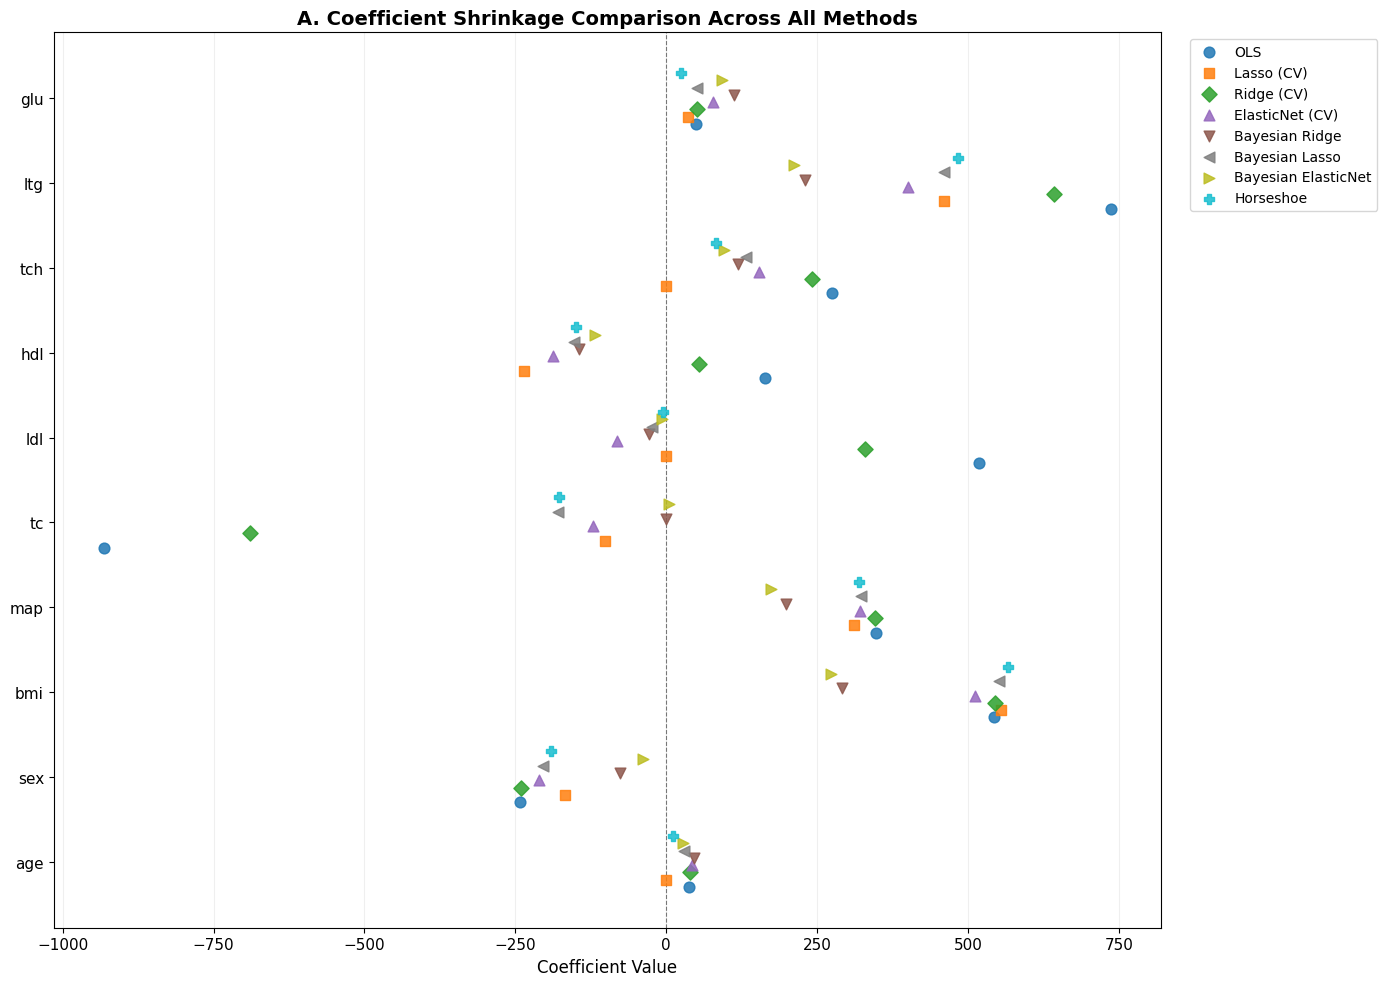

In [11]:
fig, ax = plt.subplots(figsize=(14, 10))

y_pos = np.arange(p)
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P']
colors = plt.cm.tab10(np.linspace(0, 1, len(all_models)))
offsets = np.linspace(-0.3, 0.3, len(all_models))

for i, (name, model) in enumerate(all_models.items()):
    coefs = model.get_coefficients()
    ax.scatter(coefs, y_pos + offsets[i],
               marker=markers[i % len(markers)],
               color=colors[i], label=name, s=60, zorder=3, alpha=0.85)

ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names, fontsize=11)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title('A. Coefficient Shrinkage Comparison Across All Methods',
             fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
ax.axvline(x=0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
ax.grid(axis='x', alpha=0.2)

plt.tight_layout()
plt.show()

### B. Prediction Error Comparison

Compare out-of-sample predictive performance (RMSE and R²).
Blue bars = Frequentist, orange bars = Bayesian.


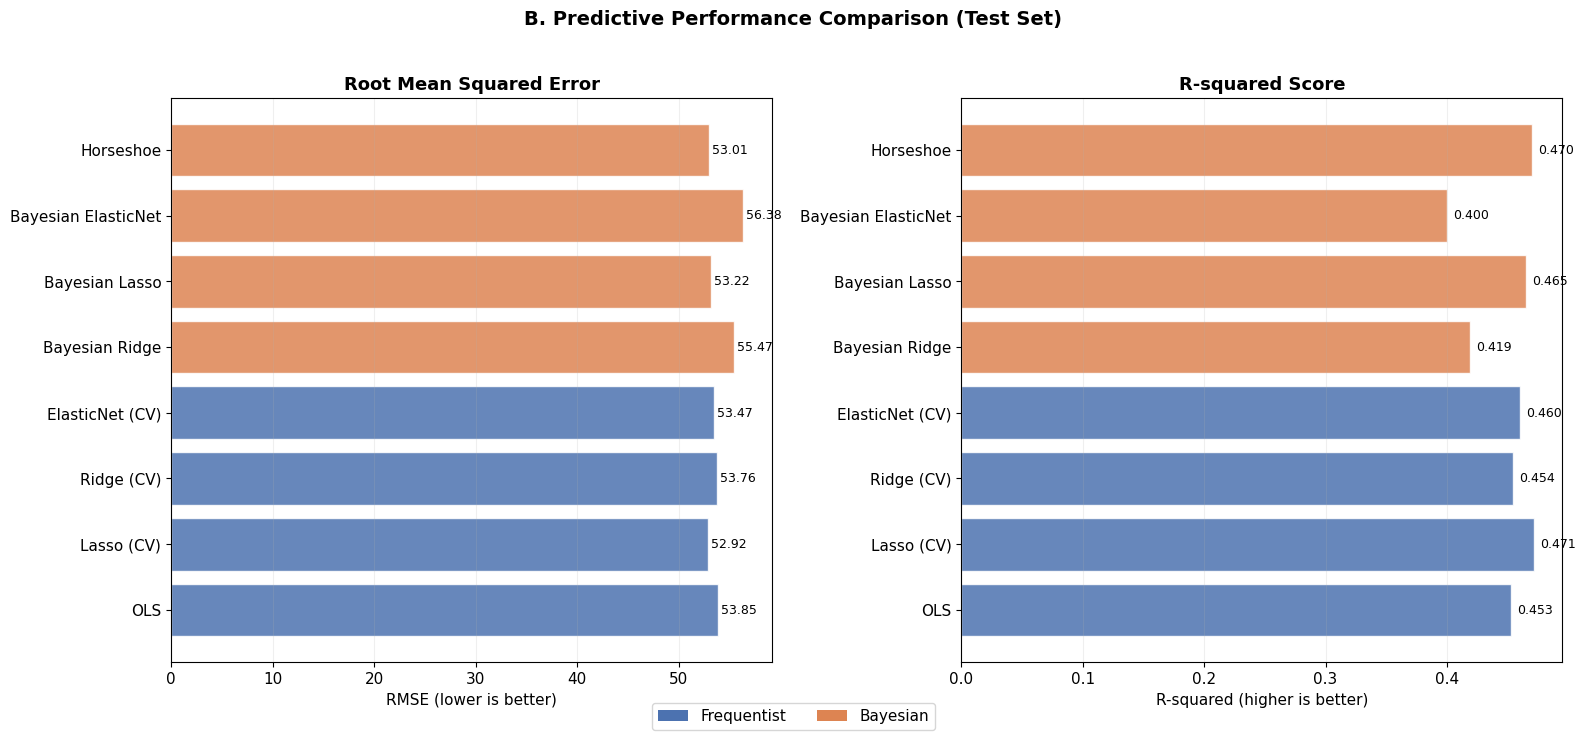

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

model_names = list(all_models.keys())
n_models = len(model_names)
colors_bar = ['#4C72B0' if not all_models[m].is_bayesian
              else '#DD8452' for m in model_names]

# --- RMSE ---
rmse_vals = [m['RMSE'] for m in metrics_list]
bars1 = axes[0].barh(model_names, rmse_vals, color=colors_bar,
                      alpha=0.85, edgecolor='white')
axes[0].set_xlabel('RMSE (lower is better)', fontsize=11)
axes[0].set_title('Root Mean Squared Error', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.2)
for bar, val in zip(bars1, rmse_vals):
    axes[0].text(val + 0.3, bar.get_y() + bar.get_height()/2,
                 f'{val:.2f}', va='center', fontsize=9)

# --- R-squared ---
r2_vals = [m['R2'] for m in metrics_list]
bars2 = axes[1].barh(model_names, r2_vals, color=colors_bar,
                      alpha=0.85, edgecolor='white')
axes[1].set_xlabel('R-squared (higher is better)', fontsize=11)
axes[1].set_title('R-squared Score', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.2)
for bar, val in zip(bars2, r2_vals):
    axes[1].text(val + 0.005, bar.get_y() + bar.get_height()/2,
                 f'{val:.3f}', va='center', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#4C72B0', label='Frequentist'),
                   Patch(facecolor='#DD8452', label='Bayesian')]
fig.legend(handles=legend_elements, loc='lower center', ncol=2,
           fontsize=11, bbox_to_anchor=(0.5, -0.02))

plt.suptitle('B. Predictive Performance Comparison (Test Set)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### C. Posterior Uncertainty Visualization (Bayesian Only)

Compare the 95% Highest Posterior Density (HPD) credible intervals
across all four Bayesian methods. Wider intervals indicate greater uncertainty.
The red dashed line at zero helps identify coefficients consistent with no effect.


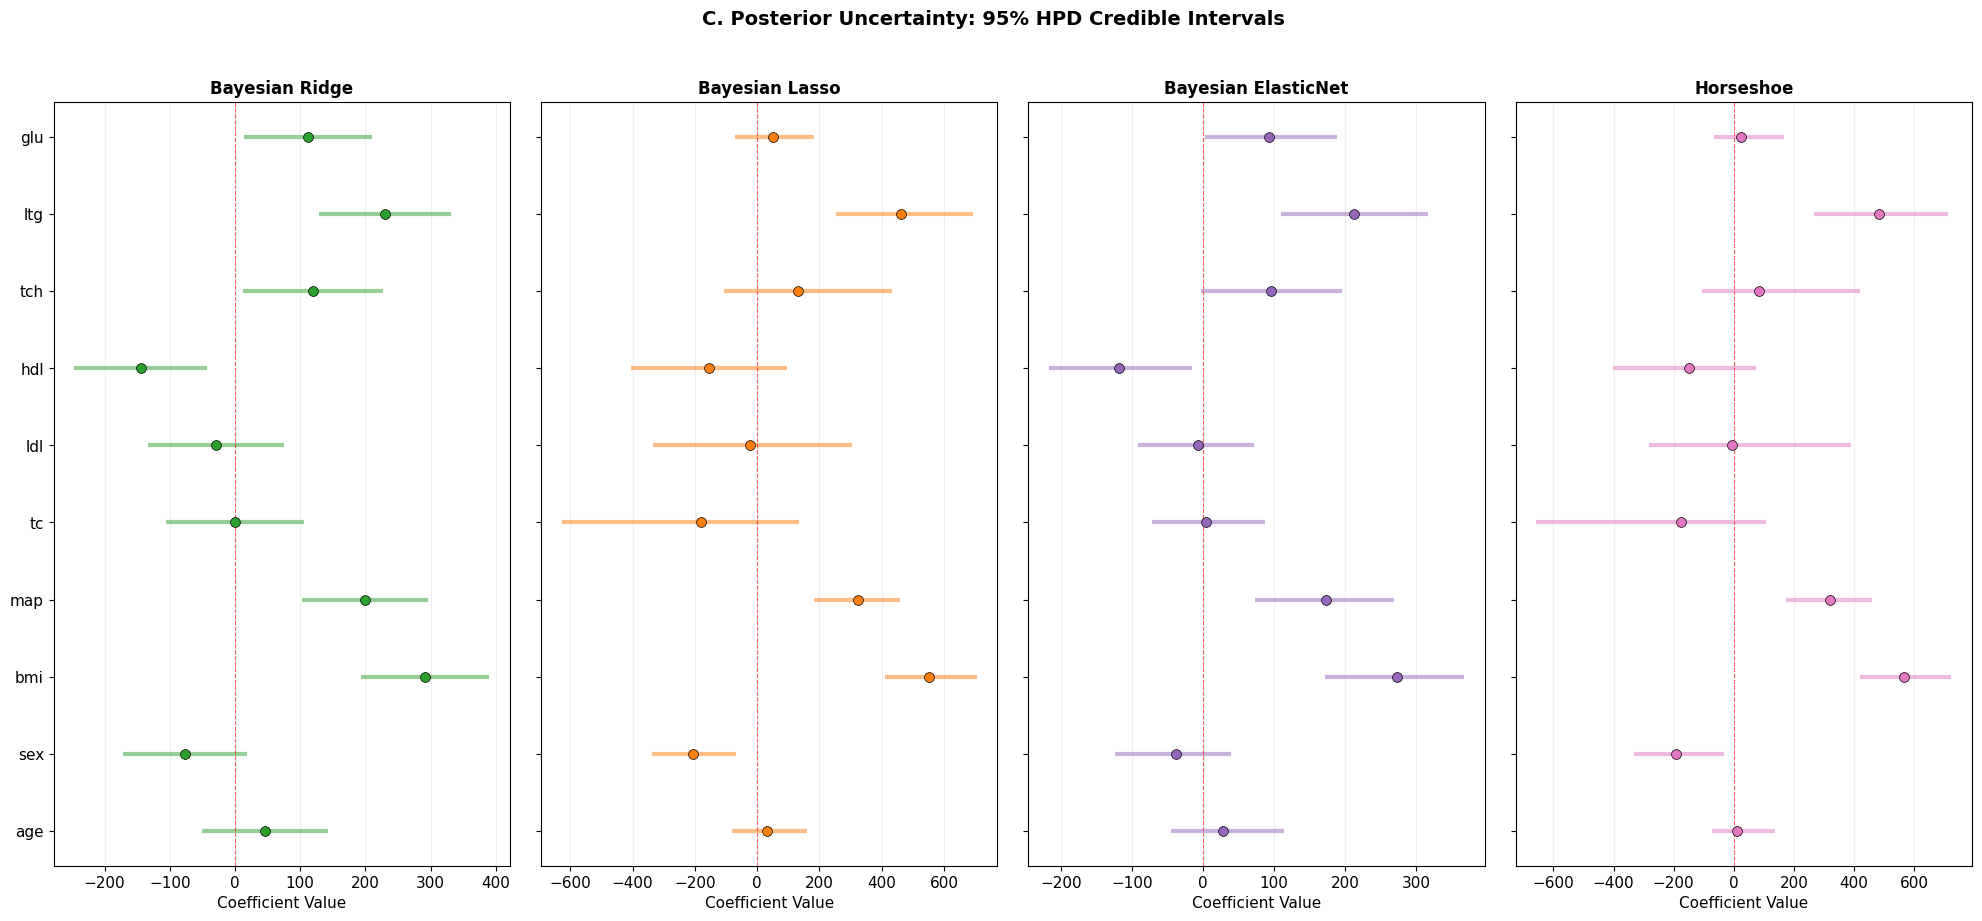

In [14]:
bayesian_models = {k: v for k, v in all_models.items() if v.is_bayesian}
n_bay = len(bayesian_models)

fig, axes = plt.subplots(1, n_bay, figsize=(5 * n_bay, 9), sharey=True)
if n_bay == 1:
    axes = [axes]

bay_colors = ['#2ca02c', '#ff7f0e', '#9467bd', '#e377c2']

for idx, (name, model) in enumerate(bayesian_models.items()):
    ax = axes[idx]
    coefs = model.get_coefficients()
    ci_lo, ci_hi = model.get_credible_intervals()

    y_pos = np.arange(p)

    # 95% HPD credible intervals
    ax.hlines(y_pos, ci_lo, ci_hi, color=bay_colors[idx],
              alpha=0.5, linewidth=3, label='95% HPD CI')

    # Posterior median point estimates
    ax.scatter(coefs, y_pos, color=bay_colors[idx], s=50,
               zorder=5, edgecolors='black', linewidth=0.5)

    # Zero reference
    ax.axvline(x=0, color='red', linewidth=0.8, linestyle='--', alpha=0.6)

    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Coefficient Value')
    ax.grid(axis='x', alpha=0.2)

axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(feature_names)

plt.suptitle('C. Posterior Uncertainty: 95% HPD Credible Intervals',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### D. Final Combined Summary Visualization

Four-panel dashboard summarizing all comparisons:

1. **Coefficient Heatmap**: Visual overview of shrinkage patterns (diverging colormap centered at zero)
2. **Test RMSE**: Predictive performance comparison
3. **Bayesian CI Overlay**: All Bayesian credible intervals on one plot for direct comparison
4. **Sparsity Profile**: Sorted absolute coefficients revealing each method's sparsity inducement


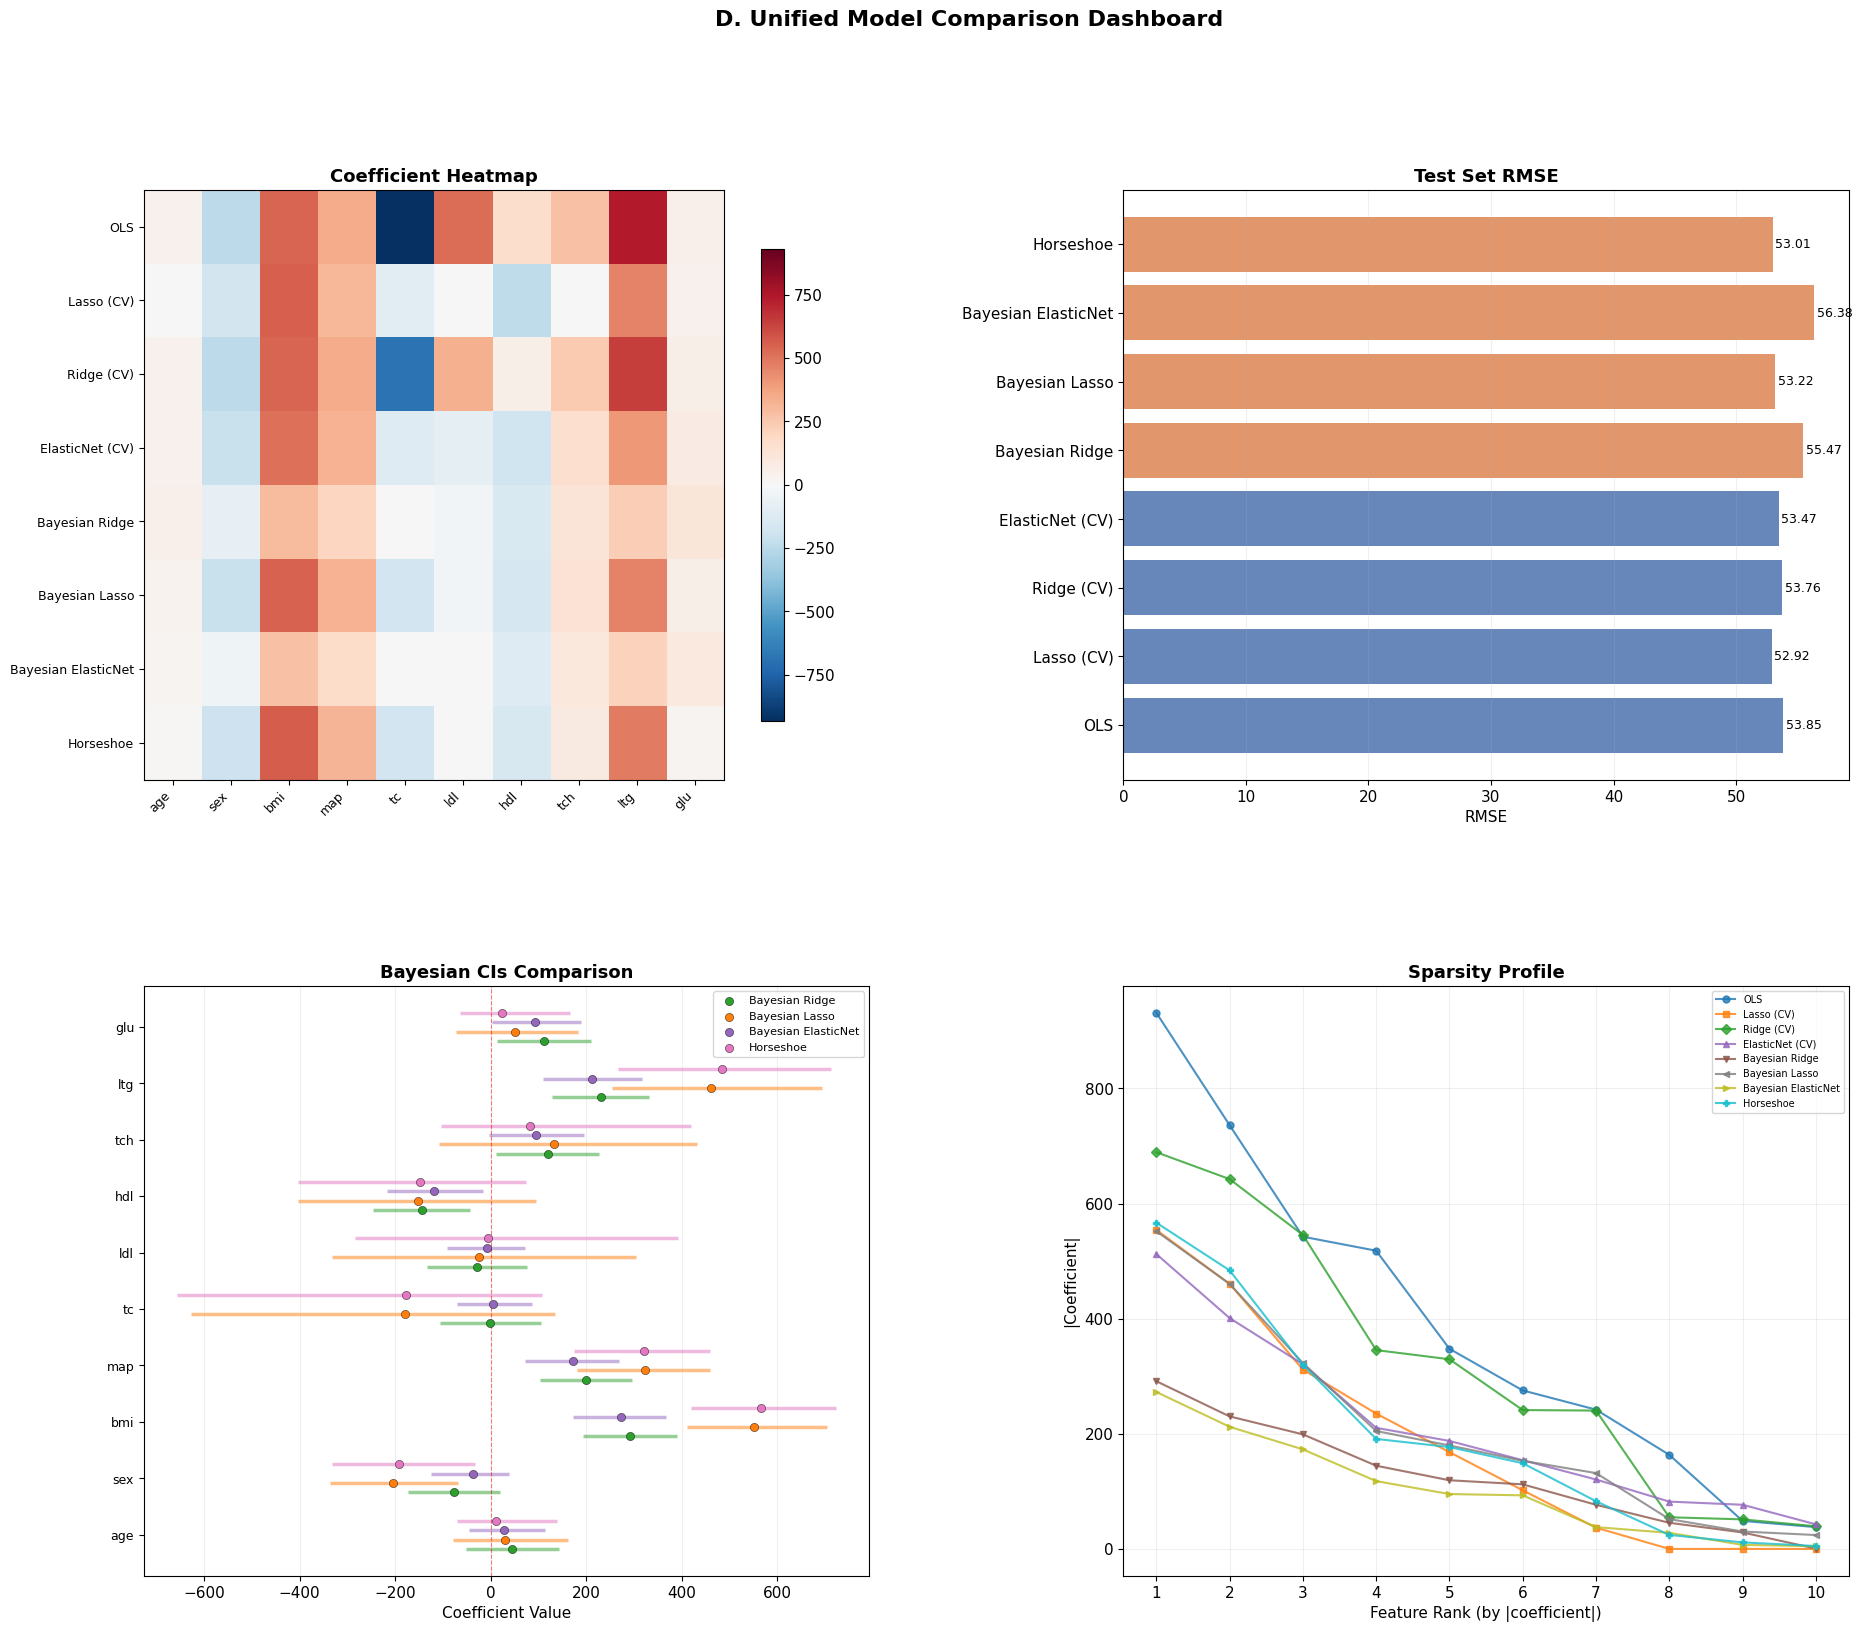

In [15]:
fig = plt.figure(figsize=(22, 18))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.35)

model_labels = list(all_models.keys())
markers_all = ['o', 's', 'D', '^', 'v', '<', '>', 'P']
colors_all = plt.cm.tab10(np.linspace(0, 1, len(all_models)))
bay_colors = ['#2ca02c', '#ff7f0e', '#9467bd', '#e377c2']

# ====== Panel 1: Coefficient Heatmap (Top-Left) ======
ax1 = fig.add_subplot(gs[0, 0])
coef_matrix = np.array([m.get_coefficients() for m in all_models.values()])
vmax = np.max(np.abs(coef_matrix))

im = ax1.imshow(coef_matrix, aspect='auto', cmap='RdBu_r',
                vmin=-vmax, vmax=vmax)
ax1.set_xticks(np.arange(p))
ax1.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=9)
ax1.set_yticks(np.arange(len(model_labels)))
ax1.set_yticklabels(model_labels, fontsize=9)
ax1.set_title('Coefficient Heatmap', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax1, shrink=0.8)

# ====== Panel 2: RMSE Bar Chart (Top-Right) ======
ax2 = fig.add_subplot(gs[0, 1])
rmse_vals = [m['RMSE'] for m in metrics_list]
bar_colors = ['#4C72B0' if not all_models[n].is_bayesian
              else '#DD8452' for n in model_labels]
bars = ax2.barh(model_labels, rmse_vals, color=bar_colors, alpha=0.85)
ax2.set_xlabel('RMSE')
ax2.set_title('Test Set RMSE', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.2)
for bar, val in zip(bars, rmse_vals):
    ax2.text(val + 0.2, bar.get_y() + bar.get_height()/2,
             f'{val:.2f}', va='center', fontsize=9)

# ====== Panel 3: Bayesian CIs Overlay (Bottom-Left) ======
ax3 = fig.add_subplot(gs[1, 0])
y_pos = np.arange(p)
ci_offsets = np.linspace(-0.25, 0.25, n_bay)

for idx, (name, model) in enumerate(bayesian_models.items()):
    coefs = model.get_coefficients()
    ci_lo, ci_hi = model.get_credible_intervals()
    offset = ci_offsets[idx]

    ax3.hlines(y_pos + offset, ci_lo, ci_hi,
               color=bay_colors[idx], alpha=0.5, linewidth=2.5)
    ax3.scatter(coefs, y_pos + offset,
                color=bay_colors[idx], s=35, zorder=5,
                label=name, edgecolors='black', linewidth=0.3)

ax3.axvline(x=0, color='red', linewidth=0.8, linestyle='--', alpha=0.5)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(feature_names, fontsize=9)
ax3.set_xlabel('Coefficient Value')
ax3.set_title('Bayesian CIs Comparison', fontsize=13, fontweight='bold')
ax3.legend(fontsize=8, loc='best')
ax3.grid(axis='x', alpha=0.2)

# ====== Panel 4: Sparsity Profile (Bottom-Right) ======
ax4 = fig.add_subplot(gs[1, 1])

for i, (name, model) in enumerate(all_models.items()):
    coefs = np.abs(model.get_coefficients())
    sorted_coefs = np.sort(coefs)[::-1]
    ax4.plot(range(1, p + 1), sorted_coefs,
             marker=markers_all[i % len(markers_all)],
             color=colors_all[i], label=name, alpha=0.8, markersize=5)

ax4.set_xlabel('Feature Rank (by |coefficient|)')
ax4.set_ylabel('|Coefficient|')
ax4.set_title('Sparsity Profile', fontsize=13, fontweight='bold')
ax4.legend(fontsize=7, loc='best')
ax4.grid(alpha=0.2)
ax4.set_xticks(range(1, p + 1))

plt.suptitle('D. Unified Model Comparison Dashboard',
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

### E. MCMC Convergence Diagnostics (Bayesian Models)

Trace plots for the first coefficient and $\sigma^2$ across Gibbs samplers.
Visual inspection for stationarity and mixing quality.


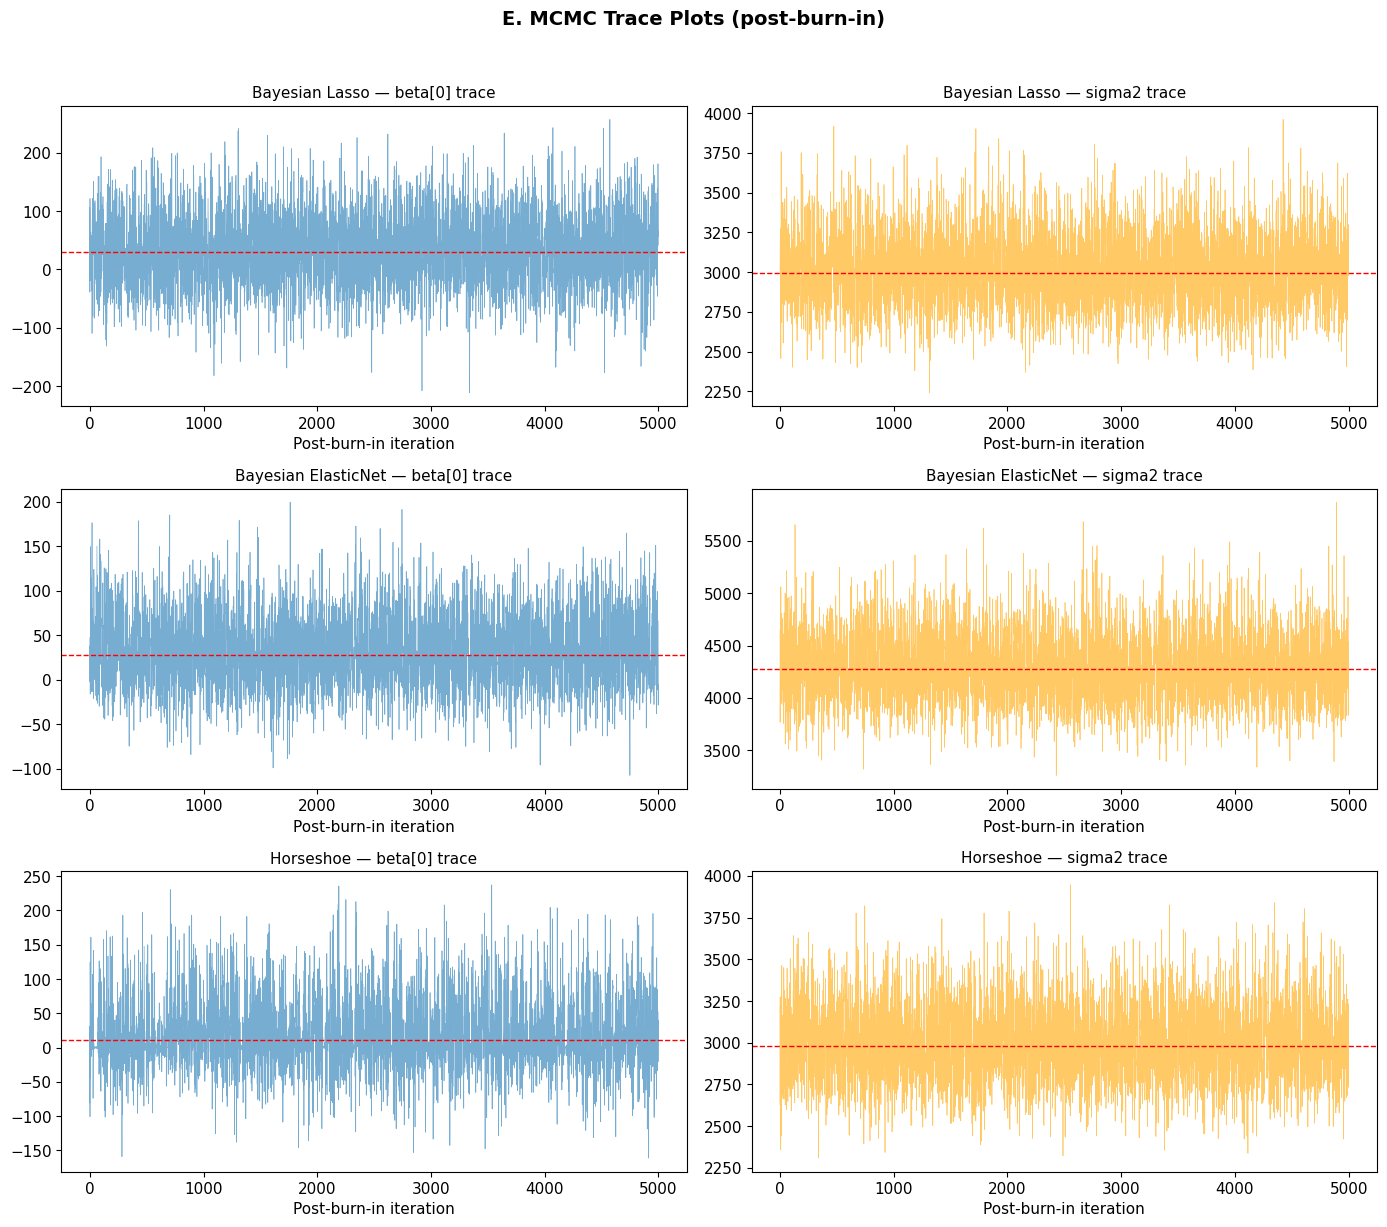

In [16]:
mcmc_models = {k: v for k, v in all_models.items()
               if v.is_bayesian and hasattr(v, 'beta_samples_')
               and hasattr(v, 'sigma2_samples_')}

# Only plot for MCMC-based models (not analytical Bayesian Ridge)
mcmc_models_trace = {k: v for k, v in mcmc_models.items()
                     if k != 'Bayesian Ridge'}

n_mcmc = len(mcmc_models_trace)
if n_mcmc > 0:
    fig, axes = plt.subplots(n_mcmc, 2, figsize=(14, 4 * n_mcmc))
    if n_mcmc == 1:
        axes = axes.reshape(1, -1)

    for idx, (name, model) in enumerate(mcmc_models_trace.items()):
        # Beta[0] trace
        axes[idx, 0].plot(model.beta_samples_[:, 0], alpha=0.6, linewidth=0.5)
        axes[idx, 0].set_title(f'{name} — beta[0] trace', fontsize=11)
        axes[idx, 0].set_xlabel('Post-burn-in iteration')
        axes[idx, 0].axhline(y=np.median(model.beta_samples_[:, 0]),
                              color='red', linewidth=1, linestyle='--')

        # Sigma2 trace
        axes[idx, 1].plot(model.sigma2_samples_, alpha=0.6, linewidth=0.5,
                          color='orange')
        axes[idx, 1].set_title(f'{name} — sigma2 trace', fontsize=11)
        axes[idx, 1].set_xlabel('Post-burn-in iteration')
        axes[idx, 1].axhline(y=np.median(model.sigma2_samples_),
                              color='red', linewidth=1, linestyle='--')

    plt.suptitle('E. MCMC Trace Plots (post-burn-in)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print('No MCMC-based models available for trace plots.')

### F. Horseshoe Shrinkage Coefficients $\kappa_j$

The horseshoe prior produces shrinkage coefficients $\kappa_j = 1/(1 + \tau^2\lambda_j^2)$
that are bimodal — concentrating near 0 (signals, no shrinkage) or 1 (noise, full shrinkage).
This is the hallmark of the horseshoe's **adaptive** shrinkage behavior.


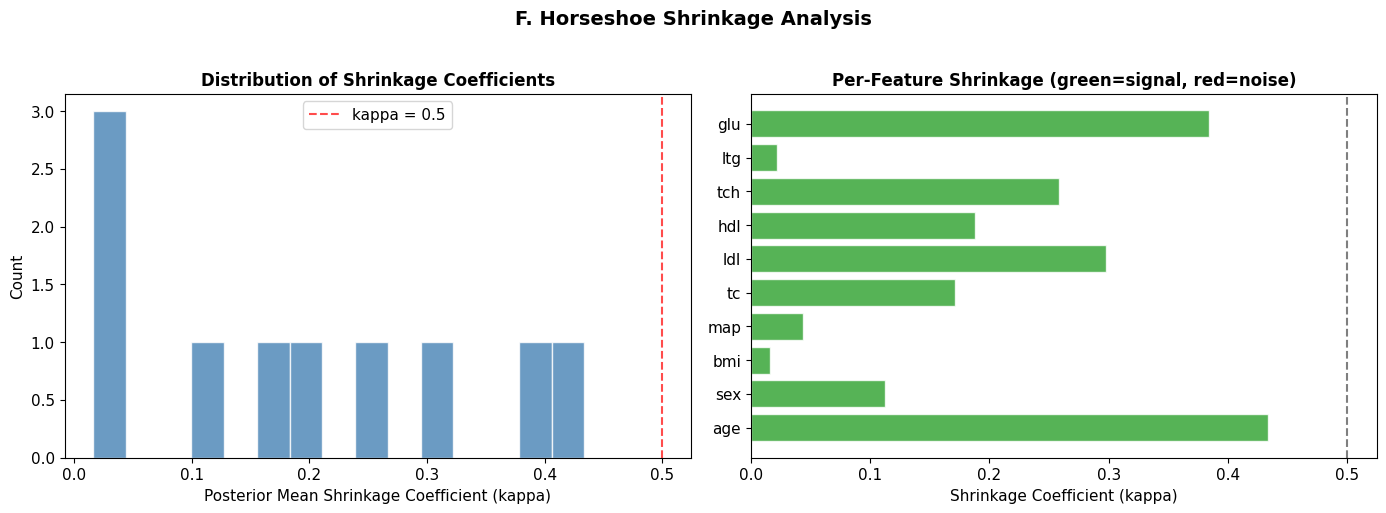

In [17]:
hs_model = all_models.get('Horseshoe')

if hs_model is not None and hasattr(hs_model, 'kappa_mean_'):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram of kappa
    axes[0].hist(hs_model.kappa_mean_, bins=15, color='steelblue',
                 edgecolor='white', alpha=0.8)
    axes[0].set_xlabel('Posterior Mean Shrinkage Coefficient (kappa)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Distribution of Shrinkage Coefficients',
                       fontsize=12, fontweight='bold')
    axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.7,
                     label='kappa = 0.5')
    axes[0].legend()

    # Kappa by feature
    y_pos = np.arange(p)
    colors_kappa = ['#d62728' if k > 0.5 else '#2ca02c'
                    for k in hs_model.kappa_mean_]
    axes[1].barh(y_pos, hs_model.kappa_mean_, color=colors_kappa,
                 alpha=0.8, edgecolor='white')
    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels(feature_names)
    axes[1].set_xlabel('Shrinkage Coefficient (kappa)')
    axes[1].set_title('Per-Feature Shrinkage (green=signal, red=noise)',
                       fontsize=12, fontweight='bold')
    axes[1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)

    plt.suptitle('F. Horseshoe Shrinkage Analysis',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

## Summary

### Key Observations

**Shrinkage behavior**:

- **OLS**: No shrinkage — largest coefficient magnitudes
- **Ridge / Bayesian Ridge**: Uniform shrinkage across all coefficients (L2 penalty)
- **Lasso / Bayesian Lasso**: Variable selection via stronger shrinkage of small coefficients (L1 penalty)
- **ElasticNet / Bayesian ElasticNet**: Balanced L1+L2 shrinkage — grouped selection with ridge stability
- **Horseshoe**: Adaptive shrinkage — preserves large signals while aggressively shrinking noise

**Bayesian advantages**:

- Full posterior distributions provide **uncertainty quantification** via credible intervals
- Hyperparameter estimation embedded in the model (no external cross-validation needed)
- Natural framework for incorporating prior knowledge

**Frequentist advantages**:

- Computationally faster (no MCMC)
- Well-established cross-validation framework for hyperparameter tuning
- Easier to scale to large datasets

### Assumptions

- **Gaussian likelihood**: $y \mid X, \beta, \sigma^2 \sim \mathcal{N}(X\beta, \sigma^2 I)$
- **Bayesian Ridge**: Conjugate Gaussian prior, weak IG hyperprior ($a = 0.001, b = 0.001$), $\lambda = 1.0$
- **Bayesian Lasso**: Gamma hyperprior on $\lambda^2$ with $r = 1, \delta = 1$
- **Bayesian Elastic Net**: Fixed $\lambda_1 = \lambda_2 = 1.0$ (could be extended with hyperpriors)
- **Horseshoe**: Non-informative half-Cauchy priors on $\tau$ and $\lambda_j$
- **MCMC**: 10,000 iterations with 5,000 burn-in; visual convergence diagnostics provided
